In [261]:
# !pip install pandas-ta
# !pip install keras
# !pip install tensorflow

In [262]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta

In [263]:
df = pd.read_excel("../Data/Histórico de Cotações-20231204.xls")
df.columns = ["Date", "Open", "Max", "Min", "Close", "Mean", "A", "Volume", "C", "D"]
df.drop(["A", "C", "D"], axis=1, inplace=True)
df = df.iloc[1:, :]
df = df.iloc[::-1]
df

,Date,Open,Max,Min,Close,Mean,Volume
4950,04/12/2003,"249,9","250,6","246,63","249,31","248,55",27733318
4949,05/12/2003,251,259,248,259,"255,65",16688622
4948,08/12/2003,258,"258,01",254,"254,98","255,81",13447694
4947,09/12/2003,257,"262,1",257,"259,5","260,19",24811950
4946,10/12/2003,260,"261,5",255,"259,5","258,96",10006041
...,...,...,...,...,...,...,...
5,27/11/2023,"30,83","30,96","30,51","30,6","30,65",553897472
4,28/11/2023,"30,59","31,05","30,48","30,9","30,87",637228224
3,29/11/2023,"31,2","31,38","30,84","31,11","31,17",702953600
2,30/11/2023,"31,3","31,66","31,23","31,59","31,48",1356884608


In [264]:
def str_to_float(x):
  return float(x.replace(",", "."))

In [265]:
df["Close"] = df["Close"].apply(str_to_float)
df["Open"] = df["Open"].apply(str_to_float)
df["Max"] = df["Max"].apply(str_to_float)
df["Min"] = df["Min"].apply(str_to_float)
df["Mean"] = df["Mean"].apply(str_to_float)

In [266]:
# RSI: Utilizado como uma característica para entender o momento do preço.
# EMAF, EMAM, EMAS: Utilizados como características para representar as médias exponenciais de diferentes períodos de tempo, ajudando a identificar tendências de longo prazo.

df['RSI']=ta.rsi(df.Close, length=15)
df['EMAF']=ta.ema(df.Close, length=20)
df['EMAM']=ta.ema(df.Close, length=100)
df['EMAS']=ta.ema(df.Close, length=150)

df['Target'] = df['Close']-df.Open
df['Target'] = df['Target'].shift(-1)
df['TargetClass'] = [1 if df.Target[i] > 0 else 0 for i in range(1, len(df)+1)]
df['TargetNextClose'] = df['Close'].shift(-1)

df.dropna(inplace=True)
df.reset_index(inplace = True)
df.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

In [267]:
data_set = df[["TargetNextClose"]]
pd.set_option('display.max_columns', None)
data_set.head(20)

,TargetNextClose
0,289.50
1,294.00
2,289.80
3,291.00
4,283.00
5,276.20
6,277.01
7,271.00
8,285.00
9,281.61


In [268]:
#Normalização dos dados para a escala entre 0 e 1.

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)

In [269]:
data_set_scaled

array([[0.52017594],
       [0.52878179],
       [0.52074967],
       ...,
       [0.02602792],
       [0.02694588],
       [0.02677376]])

In [270]:
X = data_set_scaled
y = np.array(data_set["TargetNextClose"])

In [271]:
y

array([289.5 , 294.  , 289.8 , ...,  31.11,  31.59,  31.5 ])

In [272]:
splitlimit = int(len(X)*0.8)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

In [273]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import BatchNormalization

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
tf.random.set_seed(42)
np.random.seed(10)

In [274]:
model = Sequential()
# Adjusting the number of LSTM layers and units
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(18, return_sequences=False))  # Reduce units in the final LSTM layer
# Adding additional dense layers
model.add(Dense(48, activation='relu'))
model.add(Dense(1, activation='linear'))  # Use linear activation for regression tasks
# Compile model
opt = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 1, 256)            264192    
                                                                 
 lstm_43 (LSTM)              (None, 1, 128)            197120    
                                                                 
 lstm_44 (LSTM)              (None, 1, 64)             49408     
                                                                 
 lstm_45 (LSTM)              (None, 18)                5976      
                                                                 
 dense_26 (Dense)            (None, 48)                912       
                                                                 
 dense_27 (Dense)            (None, 1)                 49        
                                                                 
Total params: 517657 (1.97 MB)
Trainable params: 5176

In [275]:
model.fit(X_train, y_train, epochs=150, batch_size=64, validation_split=0.1)

Epoch 1/150
54/54 [==============================] - 4s 18ms/step - loss: 16129.7451 - val_loss: 1155.0424
Epoch 2/150
54/54 [==============================] - 0s 4ms/step - loss: 14828.0508 - val_loss: 470.6018
Epoch 3/150
54/54 [==============================] - 0s 4ms/step - loss: 13508.2900 - val_loss: 97.1751
Epoch 4/150
54/54 [==============================] - 0s 4ms/step - loss: 12390.2324 - val_loss: 45.7070
Epoch 5/150
54/54 [==============================] - 0s 5ms/step - loss: 11626.3242 - val_loss: 292.9592
Epoch 6/150
54/54 [==============================] - 0s 4ms/step - loss: 11232.4805 - val_loss: 636.9379
Epoch 7/150
54/54 [==============================] - 0s 4ms/step - loss: 11083.8164 - val_loss: 934.2808
Epoch 8/150
54/54 [==============================] - 0s 4ms/step - loss: 10988.0537 - val_loss: 31.8671
Epoch 9/150
54/54 [==============================] - 0s 4ms/step - loss: 9585.7832 - val_loss: 0.3361
Epoch 10/150
54/54 [==============================] - 0s 4m

In [276]:
y_pred = model.predict(X_test)

30/30 [==============================] - 1s 1ms/step


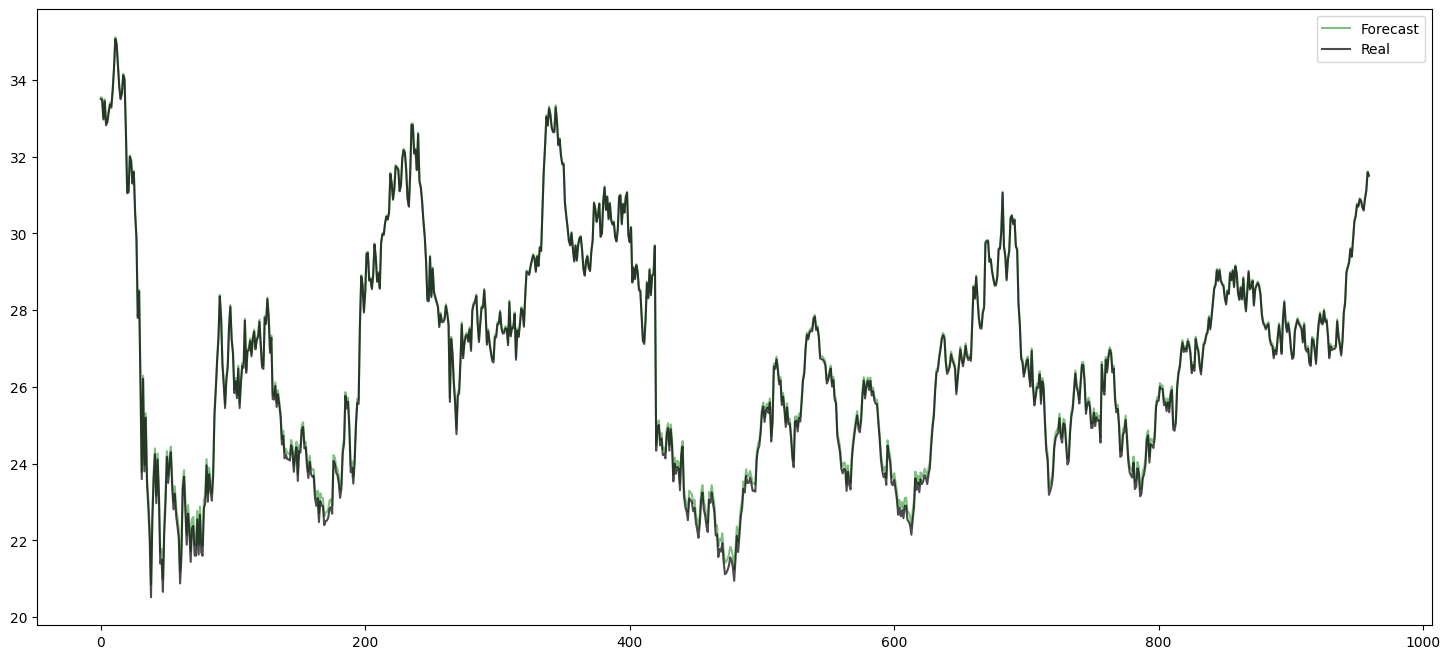

In [286]:
plt.figure(figsize=(18, 8))
plt.plot(y_pred, color='green', label='Forecast', alpha=0.5)
plt.plot(y_test, color='black', label='Real', alpha=0.7)
plt.legend()
plt.show()